In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt


In [2]:

# Load and preprocess the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11490434/11490434 [==============================] - 0s 0us/step


In [3]:

# Define the architecture of the Variational Autoencoder
input_size = 784
encoding_dim = 32

In [4]:
# Encoder
inputs = Input(shape=(input_size,))
h = Dense(256, activation='relu')(inputs)
z_mean = Dense(encoding_dim)(h)
z_log_var = Dense(encoding_dim)(h)

In [5]:
# Custom layer for sampling from the distribution
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [6]:
z = Lambda(sampling, output_shape=(encoding_dim,))([z_mean, z_log_var])

In [7]:
# Decoder
decoder_h = Dense(256, activation='relu')
decoder_mean = Dense(input_size, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [8]:
# Variational Autoencoder model
vae = Model(inputs, x_decoded_mean)


In [9]:
# Custom loss function that includes both reconstruction loss and KL divergence
xent_loss = tf.keras.losses.binary_crossentropy(inputs, x_decoded_mean)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)


In [10]:
# Compile the model
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [11]:
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 32)                   8224      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 32)                   8224      ['dense[0][0]']               
                                                                                              

In [12]:
# Train the Variational Autoencoder
vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None))


Epoch 1/50
469/469 [==============================] - 17s 24ms/step - loss: 0.3194 - val_loss: 0.2651
Epoch 2/50
469/469 [==============================] - 9s 18ms/step - loss: 0.2650 - val_loss: 0.2643
Epoch 3/50
469/469 [==============================] - 7s 16ms/step - loss: 0.2644 - val_loss: 0.2642
Epoch 4/50
469/469 [==============================] - 7s 15ms/step - loss: 0.2641 - val_loss: 0.2640
Epoch 5/50
469/469 [==============================] - 8s 16ms/step - loss: 0.2639 - val_loss: 0.2637
Epoch 6/50
469/469 [==============================] - 7s 14ms/step - loss: 0.2638 - val_loss: 0.2634
Epoch 7/50
469/469 [==============================] - 8s 17ms/step - loss: 0.2636 - val_loss: 0.2634
Epoch 8/50
469/469 [==============================] - 7s 14ms/step - loss: 0.2635 - val_loss: 0.2632
Epoch 9/50
469/469 [==============================] - 8s 17ms/step - loss: 0.2634 - val_loss: 0.2632
Epoch 10/50
469/469 [==============================] - 7s 14ms/step - loss: 0.2634 - val_l

In [13]:
# Encode and decode some digits
encoded_imgs = vae.predict(x_test)

313/313 [==============================] - 1s 3ms/step


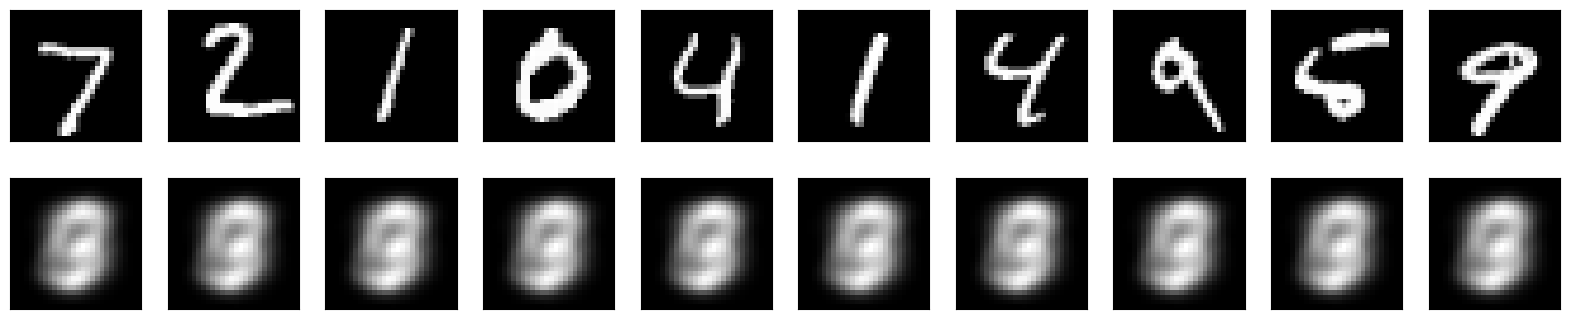

In [14]:

# Plotting original and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original Images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed Images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
